In [1]:
import os, shutil, pickle, shelve
from Bio import SeqIO
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten, Conv1D, LSTM, CuDNNLSTM, Bidirectional
from keras.optimizers import RMSprop, Adam
from keras.initializers import glorot_normal
import keras
#from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split

Using TensorFlow backend.


In [2]:
# sample data from:
data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"
output_folder_path = "../../../../temp/buffers/"

In [3]:
# Helper functions

def sampling(src, dest, num_samples, seed=42):
    """  
    Sample NUM_SAMPLES of data from SRC and copy them to DEST.
    Set random seed to be SEED.
    """
    np.random.seed(seed)
    all_data_lst = np.array(os.listdir(src))
    n = len(all_data_lst)
    sample_indices = np.random.choice(np.arange(n), num_samples, replace=False)
    sample_files = all_data_lst[sample_indices]

    for file in sample_files:
        shutil.copy(os.path.join(src, file),
                    dest)
    print('copied samples to {}'.format(dest))

def pad_for_detector(input_x, kernel_size):
    """ Pad the input matrix such that the (i, k) entry of the output 
        matrix is the score of motif detector k aligned to position i.
    input_x has shape = (N, n, 4)
    kernel_size has shape m
    output has shape = (N, n + 2m - 2, 4)
    """
    N, n, C = input_x.shape
    pad_value, num_pad = 0.25, kernel_size - 1
    pad_matrix = np.full((N, num_pad, C), pad_value)
    return np.concatenate((pad_matrix, input_x, pad_matrix), axis=1)

def one_hot_encoding(input_folder_path, output_file_path, 
                     max_file_num=10000):
    """
    Given the data in INPUT_FOLDER_PATH, encode them and save
    as a buffer called OUTPUT_FILE_PATH.
    
    Note: INPUT_FOLDER_PATH is a directory while OUTPUT_FILE_PATH
          is a file.
    """
    import os
    # Use the following dictionary to perform the transformation
    base_pairs = {'A': [1, 0, 0, 0], 
                  'C': [0, 1, 0, 0],
                  'G': [0, 0, 1, 0],
                  'T': [0, 0, 0, 1],
                  'a': [1, 0, 0, 0],
                  'c': [0, 1, 0, 0],
                  'g': [0, 0, 1, 0],
                  't': [0, 0, 0, 1],
                  'n': [0, 0, 0, 0],
                  'N': [0, 0, 0, 0]}

    file_num_limit = max_file_num    # The maximum number of files to be decoded
    file_count = 0

    # Iterate through every file
    all_regions = []
    for file in os.listdir(input_folder_path):
        # When the number of file decoded has reached the limit, stop
        if file_count < file_num_limit:
            #print(input_folder_path + file)
            data = list(SeqIO.parse(input_folder_path + file,"fasta"))
            for n in range(0, len(data)):
                # Extract the header information
                header = data[n].description.split('|')
                descr = data[n].description
                regionID = header[0]
                expressed = header[1]
                speciesID = header[2]
                strand = header[3]
                # Complement all sequences in the negative DNA strand
    #             if strand == '-':
    #                 # Using the syntax [e for e in base_pairs[n]] to create a new pointer for each position
    #                 one_hot.append([descr, expressed, speciesID, [[e for e in base_pairs[n]] for n in data[n].seq.complement()]])
    #             else:
                all_regions.append([descr, expressed, speciesID, [[e for e in base_pairs[n]] for n in data[n].seq]])
            file_count += 1

    with open(output_file_path, mode="wb") as output:
        print("save to {}".format(output_file_path))
        pickle.dump(all_regions, output)
    return all_regions

def curtail(lst, read_len):
    """ A helper function of get_training_data
    """
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0])
    return lst

def get_training_data(input_data, output_folder_path,
                      max_len, train_x_name, train_y_name):
    """ 
    Convert INPUT_DATA to ready-to-be-fed training data and 
        corresponding labels.
    Save them to OUTPUT_FOLDER_PATH with name TRAIN_X_NAME and
        TRAIN_Y_NAME.
    INPUT_DATA is directly generated by the function one_hot_encoding. 
    """
    train_x, train_y = [], []
    for region in input_data:
        y, x = int(region[1]), region[3]
        x = curtail(x, max_len)  # Curtail
        x = np.array(x).flatten() # Flatten
        x = x.reshape((1000, 4)) # Reshape
        train_x.append(x)
        train_y.append(y)

    train_x, train_y = np.array(train_x), np.array(train_y)

    print(train_x.shape, train_y.shape)

    with open(os.path.join(output_folder_path, train_x_name), mode="wb") as output:
        print("save to {}".format(os.path.join(output_folder_path, train_x_name)))
        pickle.dump(train_x, output)

    with open(os.path.join(output_folder_path, train_y_name), mode="wb") as output:
        print("save to {}".format(os.path.join(output_folder_path, train_y_name)))
        pickle.dump(train_y, output)
    return train_x, train_y

def data_split(data_x, data_y, val_split=0.2, seed=42):
    """
    Given totally N data, randomly sample N*VAL_SPLIT of them 
        to form validation data.
    Set random seed to SEED.
    """
    # Split it into training and validation data sets
    N = data_x.shape[0]
    num_val = int(N * val_split)

    np.random.seed(seed)
    val_indices = np.random.choice(np.arange(N), num_val, replace=False)
    train_indices = np.arange(N)[~np.isin(np.arange(N), val_indices)]

    train_x, train_y = data_x[train_indices], data_y[train_indices]
    val_x, val_y = data_x[val_indices], data_y[val_indices]

    print(N, train_x.shape, train_y.shape, val_x.shape, val_y.shape)
    return train_x, train_y, val_x, val_y


def dianostic_plots(train_acc, train_loss, val_train_acc, val_loss):
    """  Plot dianostic plots of a model:
    Plot 1: Traning loss & validation loss against epochs
    Plot 2: Training acc & validation acc against epochs
    """
    epochs = range(1, len(train_acc) + 1)

    plt.plot(epochs, train_acc, '-', label='Training train_accuracy')
    plt.plot(epochs, val_train_acc, '-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoches')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, '-', label='Training Loss')
    plt.plot(epochs, val_loss, '-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoches')
    plt.legend()
    
    plt.show()

In [4]:
!rm -r /home/ubuntu/data/temp/train
!mkdir /home/ubuntu/data/temp/train
!rm -r /home/ubuntu/data/temp/val
!mkdir /home/ubuntu/data/temp/val

In [5]:
# Sample training and validation data
# Make sure that they don't have intersection.
all_data_lst = np.array(os.listdir(data_dir))
n = len(all_data_lst)
train_files = all_data_lst[:500]
num_val = 100
val_indices = np.random.choice(np.arange(500, n), num_val, replace = False)
val_files = all_data_lst[val_indices]

train_dest = '/home/ubuntu/data/temp/train/'
for file in train_files:
    shutil.copy(os.path.join(data_dir, file),
                          train_dest)
print('copied training samples to {}'.format(train_dest))

val_dest = '/home/ubuntu/data/temp/val/'
for file in val_files:
    shutil.copy(os.path.join(data_dir, file),
                          val_dest)
print('copied validation samples to {}'.format(val_dest))

# Preprocess train and val data so that they are ready to be fed to models
train_output_path = os.path.join(output_folder_path, 'train.data')
val_output_path = os.path.join(output_folder_path, 'val.data')

train_regions = one_hot_encoding(train_dest, train_output_path)
val_regions = one_hot_encoding(val_dest, val_output_path)
train_x, train_y = get_training_data(train_regions, output_folder_path,
                                   max_len = 1000, 
                                   train_x_name = 'train_x.data', 
                                   train_y_name = 'train_y.data')
val_x, val_y = get_training_data(val_regions, output_folder_path,
                                   max_len = 1000, 
                                   train_x_name = 'val_x.data', 
                                   train_y_name = 'val_y.data')
# Pad for motif detectors
train_x, val_x = pad_for_detector(train_x, 15), pad_for_detector(val_x, 15)

copied training samples to /home/ubuntu/data/temp/train/
copied validation samples to /home/ubuntu/data/temp/val/
save to ../../../../temp/buffers/train.data
save to ../../../../temp/buffers/val.data
(12000, 1000, 4) (12000,)
save to ../../../../temp/buffers/train_x.data
save to ../../../../temp/buffers/train_y.data
(2400, 1000, 4) (2400,)
save to ../../../../temp/buffers/val_x.data
save to ../../../../temp/buffers/val_y.data


In [6]:
和# Define model:
class HybridModel:
    def __init__(self, K, M, input_length, rnn_size, config):
        # Extract configaration of the model:
        pool_size, strides = config['pool_size'], config['strides']
        dr1, dr2 = config['dr1'], config['dr2'] # dropout rates
        d = config['d'] # size of dense layers
        optimizer = config['opt']
        learning_rate = config['learning_rate']
        is_training = config['is_training'] # to control the dropout layers
        
        # Create the placeholders for the inputs:
        self.input = tf.placeholder(tf.float32, shape=[None, input_length, 4])
        self.targets = tf.placeholder(tf.int32, shape=[None, ])
        
        # Define layers for the model:
        self.K = K # number of filters
        
        self.conv = tf.layers.Conv1D(K, M,
                                     strides=1, padding='valid',
                                     use_bias=True, name='conv')
        self.lm_cell_fw = tf.nn.rnn_cell.LSTMCell(num_units = rnn_size, dtype = tf.float32, name='lm_cell_fw')
        self.lm_cell_bw = tf.nn.rnn_cell.LSTMCell(num_units = rnn_size, dtype = tf.float32, name='lm_cell_bw')
        
        # Feed in input
        #print(self.input.shape)
        self.activations = tf.nn.relu(self.conv(self.input))
        #print(self.activations.shape)
        outputs = tf.layers.max_pooling1d(self.activations, 
                                          pool_size=pool_size,
                                          strides=strides)
        outputs = tf.layers.dropout(outputs,
                                    rate=dr1,
                                    training=is_training)
        #print(outputs.shape)
        
        outputs, states = tf.nn.bidirectional_dynamic_rnn(self.lm_cell_fw,
                                                          self.lm_cell_bw,
                                                          outputs, dtype = tf.float32)
        outputs = tf.concat(outputs, axis=2)
        #print(outputs.shape)
        outputs = tf.layers.dropout(outputs,
                                    rate=dr2,
                                    training=is_training)
        
        outputs = tf.nn.relu(tf.layers.dense(outputs, d, name='dense1'))
        #print(outputs.shape)
        output_logits = tf.layers.dense(outputs, 1, name='dense2')
        #print(output_logits.shape)
        
        self.loss = tf.losses.sparse_softmax_cross_entropy(self.targets, output_logits)
        #print(self.loss.shape)
        self.global_step = tf.train.get_or_create_global_step()
        self.train_op = optimizer.minimize(self.loss)
        self.saver = tf.train.Saver()

In [7]:
tf.reset_default_graph() # Reset the computational graph before defining a new model.

optimizers = {'adam': tf.train.AdamOptimizer(learning_rate=1e-3),
              'rmsprop': tf.train.RMSPropOptimizer(learning_rate=1e-3)}
opt = optimizers['rmsprop']
model_config = {'pool_size': 5, 'strides': 5, 'dr1': 0.6, 'dr2': 0.7, 'd': 20, 
          'opt': opt, 'learning_rate': 1e-2, 'is_training': True}
model = HybridModel(K=30, M=15, input_length=1028, rnn_size=15, config=model_config)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling1d instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [8]:
# Define training function:
def train(model, train_x, train_y, val_x, val_y, config, verbose=True, print_every=10):
    epochs, iteration, output_path = config['epochs'], config['iteration'], config['output_path']
    val_loss_record = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            print("epoch {}".format(epoch))
            for iters in range(iteration):
                # Here is how you obtain a batch:
                batch_size = train_x.shape[0] // iteration
                #print(batch_size)
                train_indices = np.random.choice(np.arange(train_x.shape[0]), batch_size, replace=False)
                sub_train_x, sub_train_y = train_x[train_indices, :, :], train_y[train_indices]
                feed = {model.input: sub_train_x, model.targets: sub_train_y}
                model.is_training = True
                step, train_loss, _ = sess.run([model.global_step, model.loss, model.train_op], feed_dict=feed)
                if verbose:
                    if iters % print_every == 0:
                        print("    iteration {}, train_loss: {}".format(iters, train_loss))
            val_indices = np.random.choice(np.arange(val_x.shape[0]), 2400, replace = False)
            sub_val_x, sub_val_y = val_x[val_indices, :, :], val_y[val_indices]
            feed = {model.input: sub_val_x, model.targets: sub_val_y}
            model.is_training = False
            val_loss = sess.run([model.loss], feed_dict=feed)
            val_loss_record.append(val_loss)
            print("validation loss: {}".format(val_loss))
        # Here is how you save the model weights
        model.saver.save(sess, output_path)
    return val_loss_record

In [9]:
# Save the model for later analysis
save_model_path = '/home/ubuntu/data/team_neural_network/code/models'
model_name = 'hybrid_net-tensorflow.h5'
output_path = os.path.join(save_model_path, model_name)
training_config = {'epochs': 35, 'iteration': 100, 'output_path': output_path}

val_loss_record = train(model, train_x, train_y, val_x, val_y, training_config)

epoch 0
    iteration 0, train_loss: 5.316475868225098
    iteration 10, train_loss: 5.3064680099487305
    iteration 20, train_loss: 5.302048683166504
    iteration 30, train_loss: 5.244299411773682
    iteration 40, train_loss: 5.192083835601807
    iteration 50, train_loss: 5.112571716308594
    iteration 60, train_loss: 4.954061985015869
    iteration 70, train_loss: 4.788250923156738
    iteration 80, train_loss: 4.484421730041504
    iteration 90, train_loss: 4.041566848754883
validation loss: [3.4941983]
epoch 1
    iteration 0, train_loss: 3.5287530422210693
    iteration 10, train_loss: 3.017548084259033
    iteration 20, train_loss: 2.5676815509796143
    iteration 30, train_loss: 2.2607271671295166
    iteration 40, train_loss: 1.9518146514892578
    iteration 50, train_loss: 1.7613474130630493
    iteration 60, train_loss: 1.5250385999679565
    iteration 70, train_loss: 1.3509308099746704
    iteration 80, train_loss: 1.257437825202942
    iteration 90, train_loss: 1.14076

    iteration 40, train_loss: 0.5328354239463806
    iteration 50, train_loss: 0.7072104215621948
    iteration 60, train_loss: 0.582050621509552
    iteration 70, train_loss: 0.6450433135032654
    iteration 80, train_loss: 0.6060560941696167
    iteration 90, train_loss: 0.5870246291160583
validation loss: [0.8410568]
epoch 19
    iteration 0, train_loss: 0.6380292773246765
    iteration 10, train_loss: 0.5647208094596863
    iteration 20, train_loss: 0.5667112469673157
    iteration 30, train_loss: 0.5864130258560181
    iteration 40, train_loss: 0.5818300247192383
    iteration 50, train_loss: 0.6338233947753906
    iteration 60, train_loss: 0.5850740075111389
    iteration 70, train_loss: 0.5984933376312256
    iteration 80, train_loss: 0.6231352686882019
    iteration 90, train_loss: 0.6800747513771057
validation loss: [0.8884973]
epoch 20
    iteration 0, train_loss: 0.6271294951438904
    iteration 10, train_loss: 0.5974477529525757
    iteration 20, train_loss: 0.5340130925178

    iteration 0, train_loss: 0.5614534616470337
    iteration 10, train_loss: 0.5596186518669128
    iteration 20, train_loss: 0.5345996618270874
    iteration 30, train_loss: 0.5178002715110779
    iteration 40, train_loss: 0.5544251799583435
    iteration 50, train_loss: 0.5298944711685181
    iteration 60, train_loss: 0.4668157994747162
    iteration 70, train_loss: 0.5077944993972778
    iteration 80, train_loss: 0.6658449769020081
    iteration 90, train_loss: 0.5721036195755005
validation loss: [0.86555916]


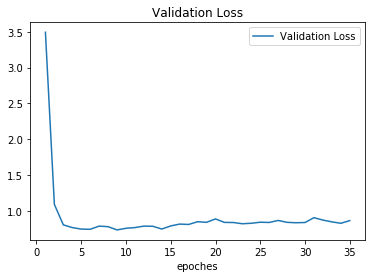

In [11]:
epochs = range(1, len(val_loss_record) + 1)

plt.plot(epochs, val_loss_record, '-', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('epoches')
plt.legend()